In [ ]:
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import GitLoader
from langchain_text_splitters import (
    Language,
    RecursiveCharacterTextSplitter,
)

import os
from datetime import datetime

# Create a unique directory name
unique_dir = f"langchain_repo_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
repo_path = os.path.join("./code_data", unique_dir)

loader = GitLoader(
    clone_url="https://github.com/langchain-ai/langchain.git",
    repo_path=repo_path,
    branch="master",
)

python_splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.PYTHON, chunk_size=10000, chunk_overlap=100
)

docs = loader.load()
docs = [doc for doc in docs if len(doc.page_content) < 50000]

In [1]:
from typing import List, Optional
from langchain_core.pydantic_v1 import BaseModel

class GraphState(BaseModel):

    question: Optional[str] = None
    generation: Optional[str] = None
    documents: List[str] = []

d:\deve\rag-langchain\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [46]:
def retriever_node(state: GraphState):
    new_documents = retriever.invoke(state.question)
    new_documents = [d.page_content for d in new_documents]
    state.documents.extend(new_documents)
    return {"documents": state.documents}

In [47]:
from langchain_core.prompts import ChatPromptTemplate

system_prompt = """
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Only provide the answer and nothing else!
"""

human_prompt = """
Question: {question}

Context: 
{context}

Answer:
"""

rag_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

In [48]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

llm_engine = ChatOpenAI(model='gpt-4o-mini')
rag_chain = rag_prompt | llm_engine | StrOutputParser()

In [49]:
def generation_node(state: GraphState):
    generation = rag_chain.invoke({
        "context": "\n\n".join(state.documents), 
        "question": state.question, 
    })
    return {"generation": generation}

In [50]:
from langgraph.graph import END, StateGraph, START

pipeline = StateGraph(GraphState)

In [51]:
pipeline.add_node('retrieval_node', retriever_node)
pipeline.add_node('generator_node', generation_node)

In [52]:
# We start by the retrieval
pipeline.add_edge(START, 'retrieval_node')

# We continue to the generation node
pipeline.add_edge('retrieval_node', 'generator_node')

# Once we generated the text, we end the pipeline
pipeline.add_edge('generator_node', END)

In [53]:
rag_pipeline = pipeline.compile()


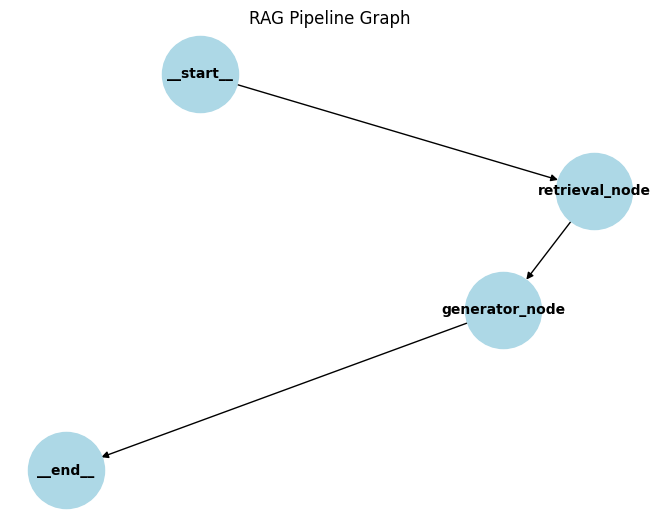

In [54]:

import networkx as nx



# Create a directed graph for pipeline

G = nx.DiGraph()
# Add nodes to the graph
G.add_node(START)
G.add_node('retrieval_node')
G.add_node('generator_node')
G.add_node(END)

# Add edges to the graph
G.add_edge(START, 'retrieval_node')
G.add_edge('retrieval_node', 'generator_node')
G.add_edge('generator_node', END)

# Visualize the graph
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=10, font_weight='bold', arrows=True)
edge_labels = {(u, v): '' for (u, v) in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("RAG Pipeline Graph")
plt.axis('off')
plt.show()






In [ ]:
inputs = {"question": "What is LangChain?"}
for output in rag_pipeline.stream(inputs, stream_mode='updates'):
    for key in output.keys():
        print(f"Node: {key}")

print(value["generation"])


SyntaxError: invalid syntax (1393414965.py, line 8)